# History of pollen levels in Eugene, OR

### The usual imports

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

### Some parameters for plotting and labeling

In [2]:
cols = ['trees', 'weeds', 'grass']
col_labels = {'trees': 'Tree pollen', 'weeds': 'Weed pollen', 'grass': 'Grass pollen'}
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthdays = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
monthstartdays = np.cumsum([0] + monthdays[:-1]) + 1
pollen_levels = ['no count', 'low', 'moderate', 'high', 'very high']

### Smoothing functions

In [3]:
def padded_array(x, pad):
    return np.concatenate((np.ones(pad) * x[0], x, np.ones(pad) * x[-1]))

def smooth(x, kernel, w, pad):
    kernel /= kernel.sum()
    x_smooth = np.convolve(x, kernel, mode='same')
    std = np.sqrt(np.convolve((x - x_smooth)**2, kernel, mode='same'))
    if pad > 0:
        x_smooth = x_smooth[pad:-pad]
    if pad > 0:
        std = std[pad:-pad]
    return x_smooth, std

def boxsmooth(x, w=1, pad=0):
    x_padded = padded_array(x, pad)
    kernel = np.ones(w) / w
    return smooth(x_padded, kernel, w, pad)

def gsmooth(x, w=1, pad=0, kernel_threshold=1e-5):
    x_padded = padded_array(x, pad)
    kernel_x = np.linspace(-x.size, x.size, x_padded.size)
    sigma = w / (2 * np.sqrt(2 * np.log(2)))
    kernel = np.exp(-kernel_x**2 / (2 * sigma**2))
    kernel[kernel < kernel_threshold] = 0
    return smooth(x_padded, kernel, w, pad)

### Least squares fit with prediction bands

In [4]:
def linear_fit(x, y):
    X = sm.add_constant(x)
    res = sm.OLS(y, X).fit()

    _, data, _  = summary_table(res, alpha=0.05)
    yfit = data[:, 2]
    ci_low, ci_upp = data[:,4:6].T
    return yfit, ci_low, ci_upp

### Load data

In [5]:
df = pd.read_csv('data/eug-or.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df = df[~((df.index.month == 2) & (df.index.day > 28))]

# All 19 years of pollen counts

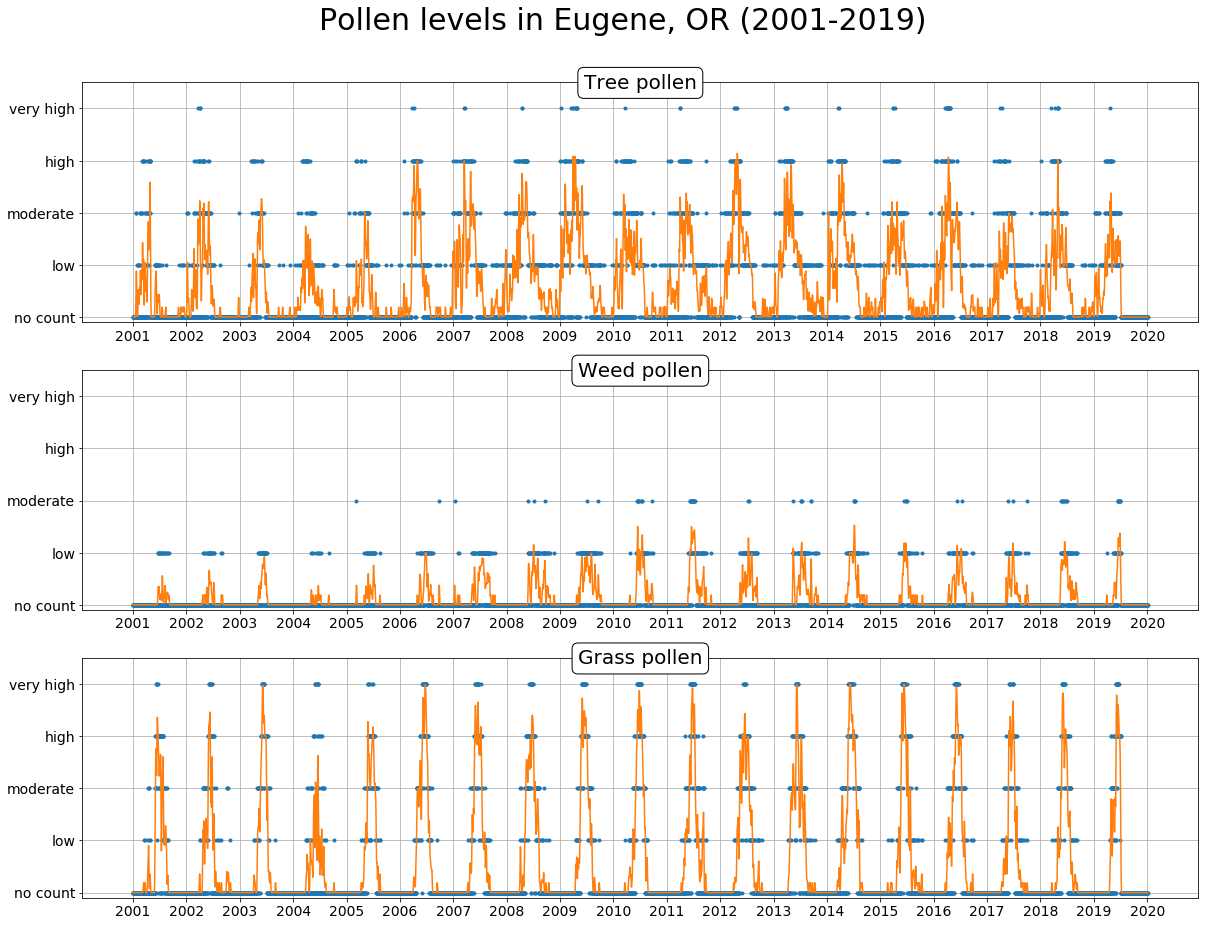

In [81]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
fig.suptitle("Pollen levels in Eugene, OR (2001-2019)", y=0.95, fontsize=30)
for i, col in enumerate(cols):
    values = df[col]
    values_smooth, _ = gsmooth(df[col].values, w=10)
    x = (df.index - df.index[0]).days
    ax[i].plot(x, values, '.')
    ax[i].plot(x, values_smooth, '-')
    ax[i].tick_params(labelsize=14)
    ax[i].set_xticks(range(x[0], x[-1], 365))
    ax[i].set_xticklabels(range(2001, 2021))
    ax[i].set_yticks(range(len(pollen_levels)))
    ax[i].set_yticklabels(pollen_levels)
    ax[i].set_title(col_labels[col], y=0.95, bbox=dict(boxstyle='round', facecolor='w'), size=20)
    ax[i].set_ylim(-0.1, 4.5)
    ax[i].grid()
fig.savefig('plots/eug-or-full.png')
plt.show()

# Monthly averages over 19 years

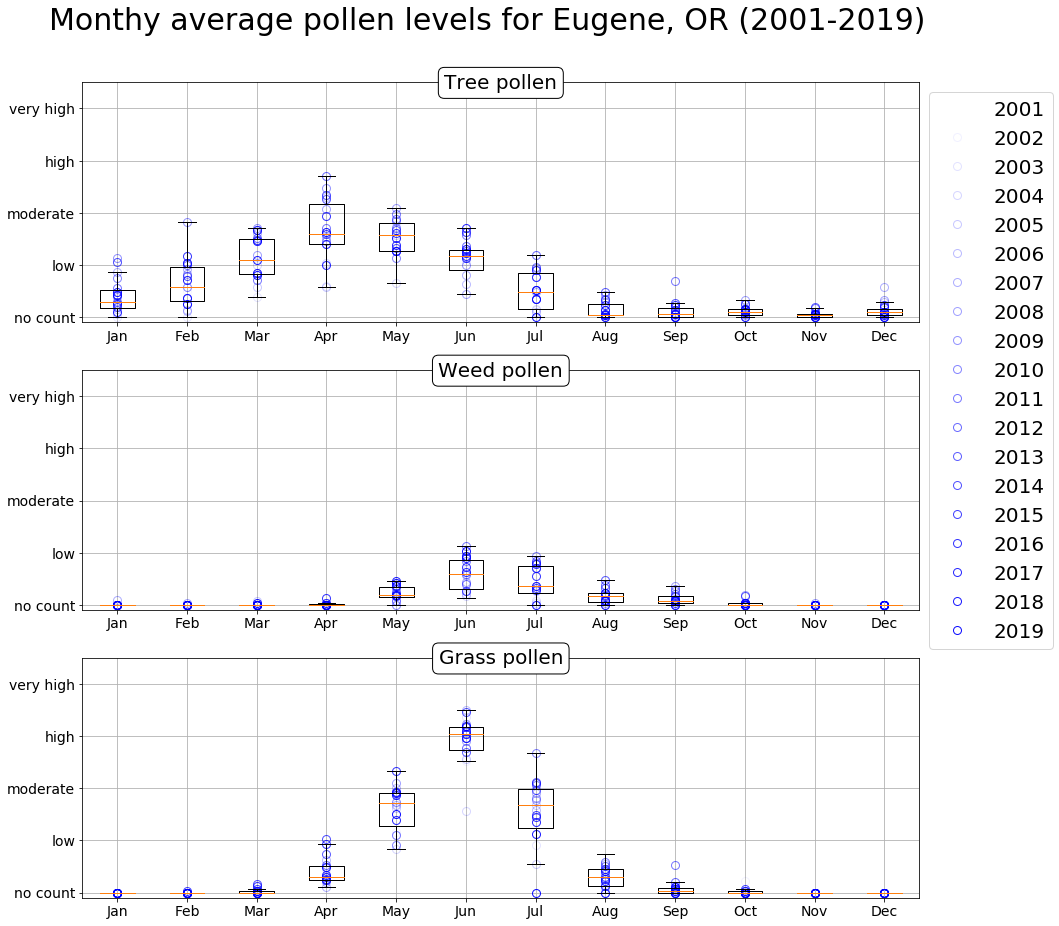

In [17]:
pv = pd.pivot_table(df, index=df.index.month, columns=df.index.year, values=cols, aggfunc='mean')
fig, ax = plt.subplots(len(cols), 1, figsize=(15, 15))
fig.suptitle("Monthy average pollen levels for Eugene, OR (2001-2019)", y=0.95, fontsize=30)
for i, col in enumerate(cols):
    years = pv[col].columns
    mean = np.mean(pv[col].values, axis=1)
    for j, year in enumerate(years):
        alpha = j / len(years)
        ax[i].plot(range(1, 13), pv[col][year].values, 'o', markersize=8, markerfacecolor='none', markeredgecolor='b', alpha=alpha, label=year)
    ax[i].boxplot(pv[col], sym='')
    ax[i].set_title(col_labels[col], y=0.95, bbox=dict(boxstyle='round', facecolor='w'), size=20)
    ax[i].tick_params(labelsize=14)
    ax[i].set_xticks(range(1, 13))
    ax[i].set_xticklabels(months)
    ax[i].set_yticks(range(len(pollen_levels)))
    ax[i].set_yticklabels(pollen_levels)
    ax[i].set_ylim(-0.1, 4.5)
    if i == 0:
        ax[i].legend(bbox_to_anchor=(1, 1), fontsize=20)
    ax[i].grid()
fig.savefig('plots/eug-or-monthly.png')
fig.show()

# Daily averages over 19 years

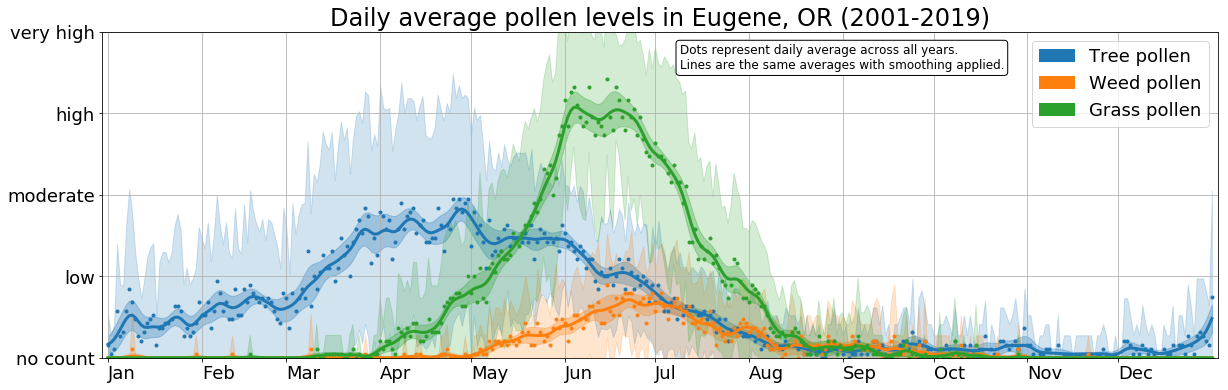

In [20]:
pv = pd.pivot_table(df, index=df.index.dayofyear, columns=df.index.year, values=cols, aggfunc='mean')
w = 10
pad = 10
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
means = []
lgd_patches = []
lgd_labels = []
for col in cols:
    days = pv.index
    mean = pv[col].mean(axis=1)
    means.append(mean)
    std = np.std(pv[col], axis=1)
    lower_bound = mean - std
    upper_bound = mean + std
    line, = ax.plot([], [])
    color = line.get_color()
    lgd_patches.append(mpatches.Patch(facecolor=color))
    label = col_labels[col] #col[0].upper() + col[1:]
    lgd_labels.append(label)
    ax.plot(days, mean.values, '.', color=color)
    ax.fill_between(x=days, y1=lower_bound, y2=upper_bound, color=color, alpha=0.2)
    mean_boxsmooth, std_boxsmooth = boxsmooth(mean.values, w=w, pad=pad)
    mean_gsmooth, std_gsmooth = gsmooth(mean.values, w=w, pad=pad)
    lower_bound = mean_gsmooth - std_gsmooth
    upper_bound = mean_gsmooth + std_gsmooth
#     ax.plot(days, mean_boxsmooth, '--', lw=3, color=color)
    ax.plot(days, mean_gsmooth, lw=3, color=color)
    ax.fill_between(x=days, y1=lower_bound, y2=upper_bound, color=color, alpha=0.3)
ax.set_title('Daily average pollen levels in Eugene, OR (2001-2019)', size=24)
ax.tick_params(labelsize=18)
ax.set_xticks(monthstartdays)
ax.set_xticklabels(months, ha='left')
ax.set_yticks(range(5))
ax.set_yticklabels(['no count', 'low', 'moderate', 'high', 'very high'])
ax.set_xlim(-1, 368)
ax.set_ylim(0, 4)
ax.legend(lgd_patches, lgd_labels, bbox_to_anchor=(1, 1), fontsize=18)
text_str = "Dots represent daily average across all years.\nLines are the same averages with smoothing applied."
text_bbox = dict(boxstyle='round', facecolor='w')
ax.text(190, 3.85, text_str, va='top', bbox=text_bbox, size=12)
ax.grid()
fig.savefig('plots/eug-or-daily.png')
fig.show()

# Pollen trends by pollen type

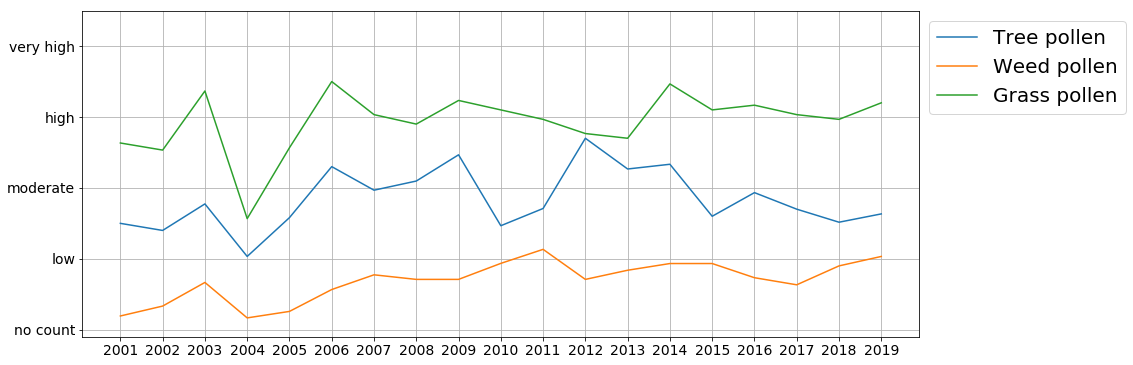

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
for i, col in enumerate(cols):
    ax.plot(pv[col].max(0), label=col_labels[col])
    ax.tick_params(labelsize=14)
    ax.set_xticks(years)
    ax.set_yticks(range(len(pollen_levels)))
    ax.set_yticklabels(pollen_levels)
    ax.set_ylim(-0.1, 4.5)
    ax.grid()
    ax.legend(bbox_to_anchor=(1, 1), fontsize=20)
plt.show()

# Pollen trends by type and month

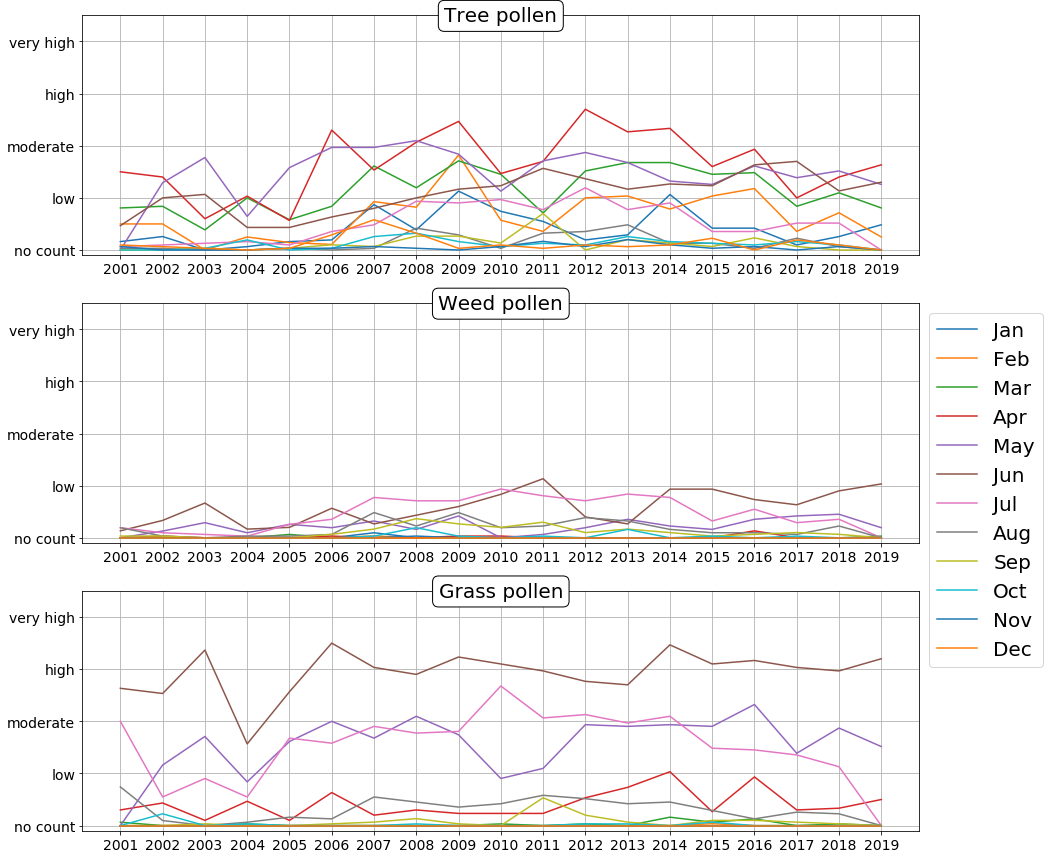

In [25]:
fig, ax = plt.subplots(len(cols), 1, figsize=(15, 15))
for i, col in enumerate(cols):
    years = pv[col].columns
    for j, month in enumerate(months):
        ax[i].plot(years, pv[col].loc[j + 1], label=month)
    ax[i].tick_params(labelsize=14)
    ax[i].set_xticks(years)
    ax[i].set_yticks(range(len(pollen_levels)))
    ax[i].set_yticklabels(pollen_levels)
    ax[i].set_title(col_labels[col], y=0.95, bbox=dict(boxstyle='round', facecolor='w'), size=20)
    ax[i].set_ylim(-0.1, 4.5)
    ax[i].grid()
ax[1].legend(bbox_to_anchor=(1, 1), fontsize=20)
plt.show()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


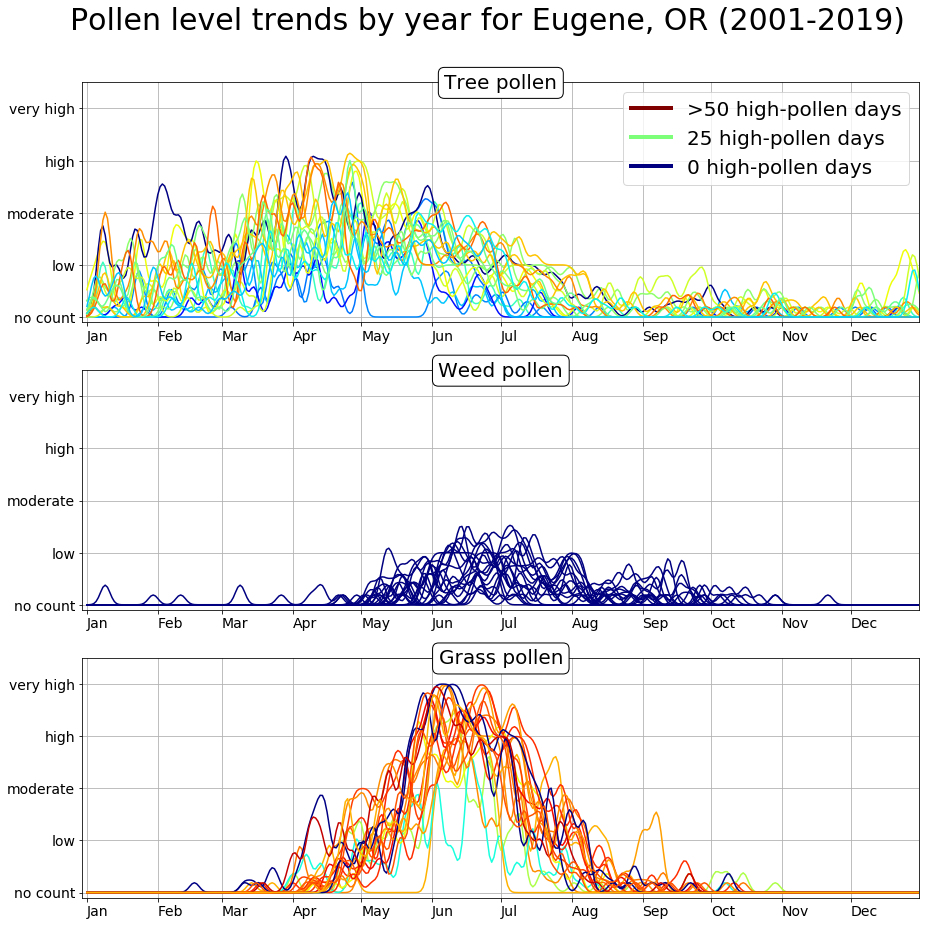

In [77]:
fig, ax = plt.subplots(len(cols), 1, figsize=(15, 15))
fig.suptitle("Pollen level trends by year for Eugene, OR (2001-2019)", y=0.95, fontsize=30)
years = np.unique(df.index.year)
cmap = plt.cm.jet
for i, col in enumerate(cols):
    for year in years:
        series = df[col][df.index.year == year]
        x = series.index.dayofyear
        highs = np.sum(series > 2)
        y, yerr = gsmooth(series.values , w=10, pad=0)
        ax[i].plot(x, y, color=cmap(min(1, highs / 50)))
    ax[i].set_title(col_labels[col], y=0.95, bbox=dict(boxstyle='round', facecolor='w'), size=20)
    ax[i].tick_params(labelsize=14)
    ax[i].set_xticks(monthstartdays)
    ax[i].set_xticklabels(months, ha='left')
    ax[i].set_yticks(range(len(pollen_levels)))
    ax[i].set_yticklabels(pollen_levels)
    ax[i].set_xlim(-1, 365)
    ax[i].set_ylim(-0.1, 4.5)
    if i == 0:
        lines = [
            mlines.Line2D([0], [0], color=cmap(1.0), lw=4),
            mlines.Line2D([0], [0], color=cmap(0.5), lw=4),
            mlines.Line2D([0], [0], color=cmap(0.0), lw=4)
        ]
        ax[i].legend(lines, ['>50 high-pollen days',  '25 high-pollen days', '0 high-pollen days'], bbox_to_anchor=(1, 1), fontsize=20)
    ax[i].grid()
# fig.savefig('plots/eug-or-monthly.png')
fig.show()

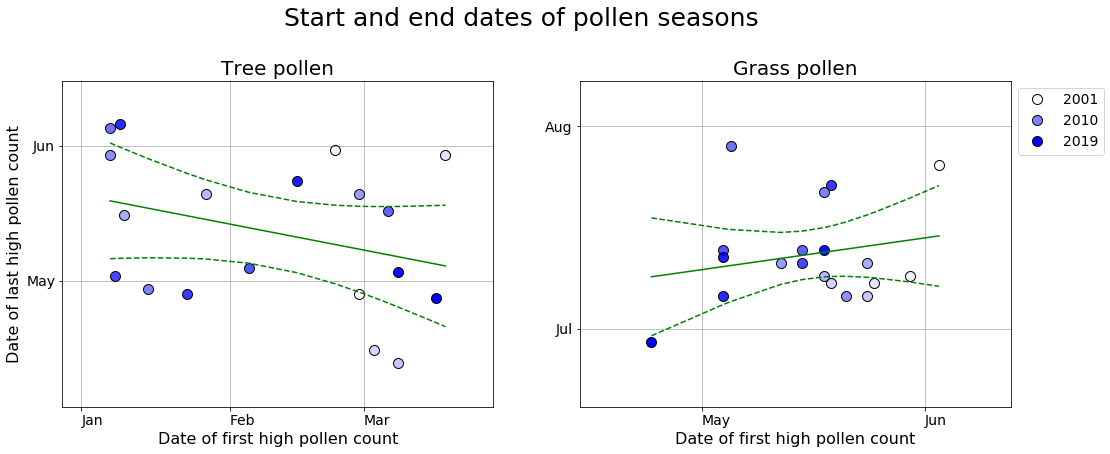

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(17, 6))
fig.suptitle("Start and end dates of pollen seasons", y=1.05, fontsize=25)
years = np.unique(df.index.year)
label_years = [2001, 2010, 2019]
cmap = plt.cm.jet
for i, col in enumerate(['trees', 'grass']):
    last, first = np.zeros((2, len(years)))
    for j, year in enumerate(years):
        series = df[col][df.index.year == year]
        series = series[series.values > 2][:-1]
        last[j] = series.index.dayofyear[-1]
        first[j] = series.index.dayofyear[0]
        alpha = (year - years[0]) / (years[-1] - years[0])
        label = year if year in label_years else None
        ax[i].plot(first[j], last[j], 'bo', ms=10, markerfacecolor=(0, 0, 1, alpha), markeredgecolor='k', label=label)
    sort_idx = np.argsort(first)
    x, y = first[sort_idx], last[sort_idx]
    yfit, ci_low, ci_upp = linear_fit(x, y)
    ax[i].plot(x, yfit, 'g')
    ax[i].plot(x, ci_low, 'g--')
    ax[i].plot(x, ci_upp, 'g--')
    ax[i].set_title(col_labels[col], size=20)
    ax[i].set_xlabel("Date of first high pollen count", size=16)
    if i == 0:
        ax[i].set_ylabel("Date of last high pollen count", size=16)
    ax[i].tick_params(labelsize=14)
    ax[i].set_xticks(monthstartdays)
    ax[i].set_xticklabels(months, ha='left')
    ax[i].set_yticks(monthstartdays)
    ax[i].set_yticklabels(months)
    ax[i].set_xlim(first.min() - 10, first.max() + 10)
    ax[i].set_ylim(last.min() - 10, last.max() + 10)
    ax[i].grid()
    if i == 1:
        ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)
# fig.savefig('plots/eug-or-monthly.png')
plt.show()

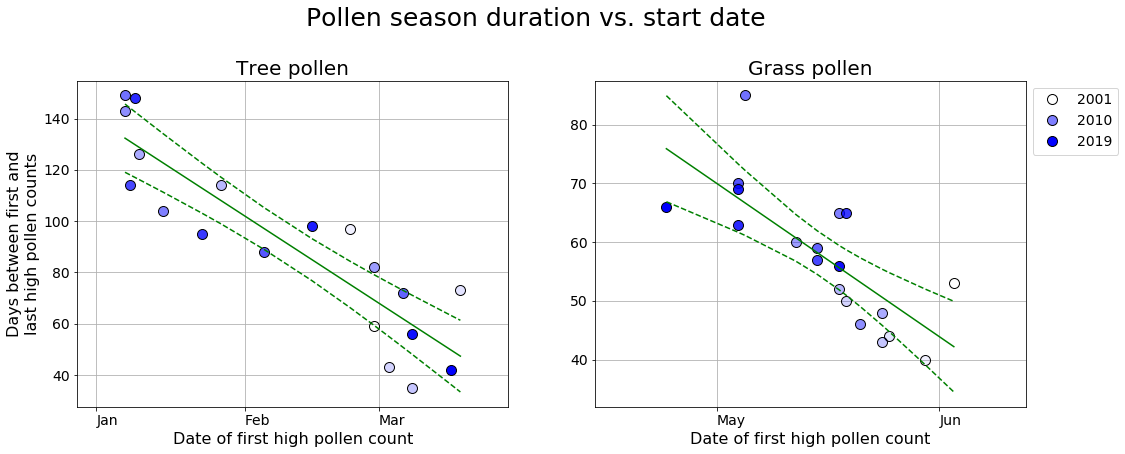

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(17, 6))
fig.suptitle("Pollen season duration vs. start date", y=1.05, fontsize=25)
years = np.unique(df.index.year)
label_years = [2001, 2010, 2019]
cmap = plt.cm.jet
for i, col in enumerate(['trees', 'grass']):
    period, first = np.zeros((2, len(years)))
    for j, year in enumerate(years):
        series = df[col][df.index.year == year]
        series = series[series.values > 2][:-1]
        period[j] = (series.index[-1] - series.index[0]).days
        first[j] = series.index.dayofyear[0]
        alpha = (year - years[0]) / (years[-1] - years[0])
        label = year if year in label_years else None
        ax[i].plot(first[j], period[j], 'bo', ms=10, markerfacecolor=(0, 0, 1, alpha), markeredgecolor='k', label=label)
    sort_idx = np.argsort(first)
    x, y = first[sort_idx], period[sort_idx]
    yfit, ci_low, ci_upp = linear_fit(x, y)
    ax[i].plot(x, yfit, 'g')
    ax[i].plot(x, ci_low, 'g--')
    ax[i].plot(x, ci_upp, 'g--')
    ax[i].set_title(col_labels[col], size=20)
    ax[i].set_xlabel("Date of first high pollen count", size=16)
    if i == 0:
        ax[i].set_ylabel("Days between first and\nlast high pollen counts", size=16)
    ax[i].tick_params(labelsize=14)
    ax[i].set_xticks(monthstartdays)
    ax[i].set_xticklabels(months, ha='left')
    ax[i].set_xlim(first.min() - 10, first.max() + 10)
    ax[i].grid()
    if i == 1:
        ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)
# fig.savefig('plots/eug-or-monthly.png')
plt.show()

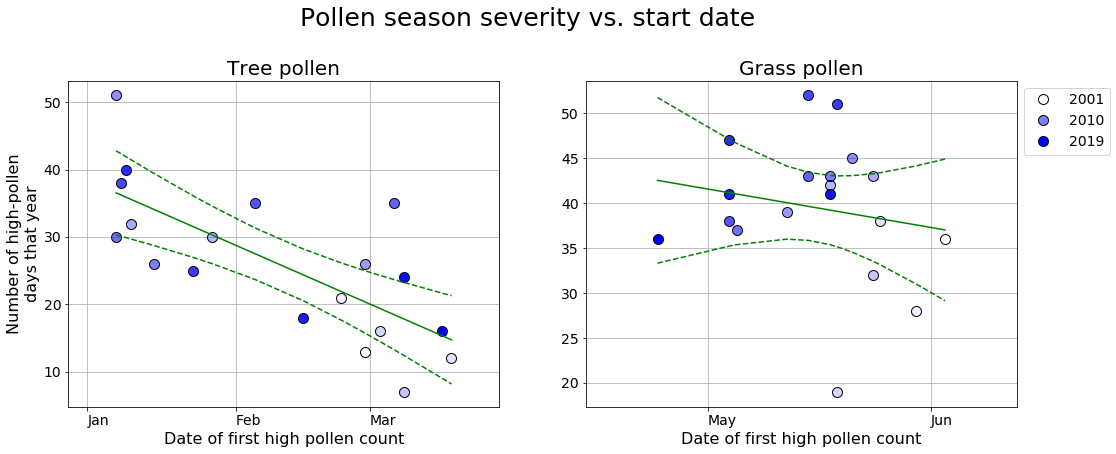

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(17, 6))
fig.suptitle("Pollen season severity vs. start date", y=1.05, fontsize=25)
years = np.unique(df.index.year)
label_years = [2001, 2010, 2019]
cmap = plt.cm.jet
for i, col in enumerate(['trees', 'grass']):
    highs, first = np.zeros((2, len(years)))
    for j, year in enumerate(years):
        series = df[col][df.index.year == year]
        highs[j] = np.sum(series.values > 2)
        first[j] = series.index.dayofyear[np.argmax(series.values > 2)]
        alpha = (year - years[0]) / (years[-1] - years[0])
        label = year if year in label_years else None
        ax[i].plot(first[j], highs[j], 'bo', ms=10, markerfacecolor=(0, 0, 1, alpha), markeredgecolor='k', label=label)
    sort_idx = np.argsort(first)
    x, y = first[sort_idx], highs[sort_idx]
    yfit, ci_low, ci_upp = linear_fit(x, y)
    ax[i].plot(x, yfit, 'g')
    ax[i].plot(x, ci_low, 'g--')
    ax[i].plot(x, ci_upp, 'g--')
    ax[i].set_title(col_labels[col], size=20)
    ax[i].set_xlabel("Date of first high pollen count", size=16)
    if i == 0:
        ax[i].set_ylabel("Number of high-pollen\ndays that year", size=16)
    ax[i].tick_params(labelsize=14)
    ax[i].set_xticks(monthstartdays)
    ax[i].set_xticklabels(months, ha='left')
    ax[i].set_xlim(first.min() - 10, first.max() + 10)
    ax[i].grid()
    if i == 1:
        ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)
# fig.savefig('plots/eug-or-monthly.png')
plt.show()

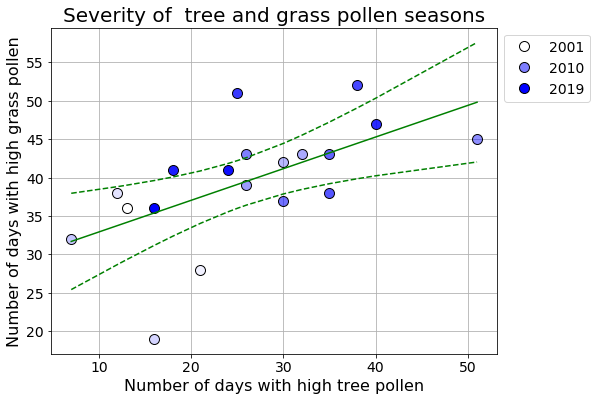

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
years = np.unique(df.index.year)
label_years = [2001, 2010, 2019]
cmap = plt.cm.jet
trees, grass = np.zeros((2, len(years)))
for j, year in enumerate(years):
    subset = df[df.index.year == year]
    trees[j] = np.sum(subset['trees'].values > 2)
    grass[j] = np.sum(subset['grass'].values > 2)
    alpha = (year - years[0]) / (years[-1] - years[0])
    label = year if year in label_years else None
    ax.plot(trees[j], grass[j], 'bo', ms=10, markerfacecolor=(0, 0, 1, alpha), markeredgecolor='k', label=label)
sort_idx = np.argsort(trees)
x, y = trees[sort_idx], grass[sort_idx]
yfit, ci_low, ci_upp = linear_fit(x, y)
ax.plot(x, yfit, 'g')
ax.plot(x, ci_low, 'g--')
ax.plot(x, ci_upp, 'g--')
ax.set_title("Severity of  tree and grass pollen seasons", fontsize=20)
ax.set_xlabel("Number of days with high tree pollen", size=16)
ax.set_ylabel("Number of days with high grass pollen", size=16)
ax.tick_params(labelsize=14)
ax.grid()
if i == 1:
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)
# fig.savefig('plots/eug-or-monthly.png')
plt.show()